# Baseline Model

## Table of Contents
1. [Model Choice](#1-model-choice-persistence-baseline)
2. [Implementation](#2-implementation)
3. [Evaluation](#3-evaluation-metrics)


In [2]:
import xarray as xr


## 1. Model Choice: Persistence Baseline

To evaluate the predictive skill of the surface emulator, a **Persistence Model** is established as the primary baseline. 

### 1.1 Definition of Persistence
In the context of this study, persistence (also known as the "naive" or "frozen" forecast) assumes that the state of the ocean at time $t + \Delta t$ is identical to the state at time $t$. Specifically, for the weekly mean potential temperature field $\theta_o$:

$$\hat{\theta}_{o}(t + 1) = \theta_{o}(t)$$

where $\hat{\theta}_{o}$ is the predicted field for the following week.

### 1.2 Justification as a Benchmark
The persistence model is a reasonable and necessary benchmark for several physical and numerical reasons:

* **High Autocorrelation:** Sea Surface Temperature (SST) exhibits high temporal autocorrelation due to the large thermal inertia of the ocean's mixed layer. On a weekly scale, the broad-scale thermal patterns change slowly, making persistence a surprisingly difficult baseline to beat.
* **Measurement of "True" Skill:** Any machine learning architecture (e.g., U-Net or ViT) must demonstrate that it is learning the underlying advective and diffusive physics rather than simply memorizing the current state. If a model's Error (RMSE) is higher than that of persistence, the model has "negative skill."
* **Capturing Anomalies:** By comparing our emulator against persistence, we can quantify the model's ability to predict **non-persistent changes**, such as the rapid intensification of upwelling filaments or the propagation of mesoscale eddies, which are the most dynamically significant features of the North West African coast.

| Baseline | Complexity | Physical Assumption | Metric for Success |
| :--- | :--- | :--- | :--- |
| **Persistence** | Zero Parameters | Static Equilibrium | $\text{RMSE}_{Model} < \text{RMSE}_{Persistence}$ |

## 2. Implementation

In [ ]:
import os

# Path to the weekly-resampled, 512x512 CMEMS SST dataset.
# Update this to point to your local copy.
DATA_DIR = os.path.join('..', 'data')
file_path = os.path.join(DATA_DIR, 'CMEMS_thetao_weekly_512.nc')

sst_dataset = xr.open_dataset(file_path)


In [4]:
import numpy as np
import xarray as xr

def get_persistence_predictions(ds, variable='thetao', test_split=0.2):
    """
    Generates persistence 'predictions' and corresponding ground truth pairs.
    
    Returns:
        y_true: Array of actual states for the test period.
        y_pred: Array of persistence states (t-1) for the test period.
        time_coords: The time coordinates corresponding to the test period.
    """
    n_time = len(ds.time)
    test_size = int(n_time * test_split)
    
    # Define indices for the test period
    # We need t-1 for the first test index, so we ensure indices are valid
    test_indices = np.arange(n_time - test_size, n_time)
    
    # Extract Ground Truth (Y) and Persistence Forecast (X)
    # y_pred[i] is the state at ds.time[test_indices[i] - 1]
    y_true = ds[variable].isel(time=test_indices).values
    y_pred = ds[variable].isel(time=test_indices - 1).values
    
    test_times = ds.time.isel(time=test_indices).values
    
    return y_true, y_pred, test_times

# Generate the data for evaluation
y_true, y_pred, test_dates = get_persistence_predictions(sst_dataset)


## 3. Evaluation Metrics

To evaluate the predictive accuracy of the surface emulator against the persistence baseline, we utilize two primary statistical metrics: Mean Squared Error (MSE) and Root Mean Square Error (RMSE).

### 3.1 Mean Squared Error (MSE)
Mean Squared Error is employed as the primary loss function during model training and as a core performance metric. It is defined as the average of the squares of the errors:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Justification for MSE:**
* **Sensitivity to Outliers:** By squaring the residuals, MSE disproportionately penalizes larger deviations. In the context of the North West African Upwelling Region, this ensures the model remains sensitive to sharp thermal gradients and extreme anomalies.
* **Optimization Properties:** MSE provides a smooth, differentiable surface for gradient descent. This allows the neural network to converge efficiently by providing a clear signal for backpropagation across the $512 \times 512$ spatial grid.

### 3.2 Root Mean Square Error (RMSE)
While MSE is ideal for numerical optimization, the Root Mean Square Error is used for the physical interpretation of the results:

$$RMSE = \sqrt{MSE}$$

**Justification for RMSE:**
* **Physical Interpretability:** Unlike MSE, RMSE shares the same units as the target variable ($^\circ\text{C}$). This allows for a direct assessment of the model's error relative to the actual temperature values of the Atlantic.
* **Benchmark Comparison:** RMSE provides a standard measure to compare model skill against the persistence baseline and the natural climatic variability (standard deviation) of the dataset. 

In [5]:
from skimage.metrics import structural_similarity as ssim

def evaluate_persistence_performance(y_true, y_pred, global_range):
    """
    Calculates spatial and temporal error metrics for the persistence arrays.
    """
    mse_list, rmse_list, ssim_list = [], [], []
    
    # Iterate through the test snapshots
    for i in range(len(y_true)):
        target = y_true[i]
        prediction = y_pred[i]
        
        # Create mask for valid ocean pixels (ignores NaNs from African landmass)
        mask = ~np.isnan(target) & ~np.isnan(prediction)
        
        if not np.any(mask): continue
        
        # 1. Squared Error Metrics
        mse = np.mean((target[mask] - prediction[mask])**2)
        rmse = np.sqrt(mse)
        
        mse_list.append(mse)
        rmse_list.append(rmse)
        
        # 2. Structural Similarity (SSIM)
        # Fill land NaNs with the mean to avoid artificial 'edge' artifacts at the coast
        fill_val = np.nanmean(target)
        t_filled = np.nan_to_num(target, nan=fill_val)
        p_filled = np.nan_to_num(prediction, nan=fill_val)
        
        s_val = ssim(t_filled, p_filled, data_range=global_range)
        ssim_list.append(s_val)
        
    # Aggregate results
    return {
        "MSE": np.mean(mse_list),
        "RMSE": np.mean(rmse_list),
        "SSIM": np.mean(ssim_list),
        "Peak_RMSE": np.max(rmse_list)
    }

# --- EXECUTION ---
# Standardize range based on the test set for fair SSIM comparison
data_min = np.nanmin(y_true)
data_max = np.nanmax(y_true)
test_range = data_max - data_min

metrics = evaluate_persistence_performance(y_true, y_pred, test_range)

print(f"--- Persistence Evaluation (Test Set) ---")
print(f"Mean MSE:  {metrics['MSE']:.5f}")
print(f"Mean RMSE: {metrics['RMSE']:.4f} °C")
print(f"Max Error: {metrics['Peak_RMSE']:.4f} °C")


--- Persistence Evaluation (Test Set) ---
Mean MSE:  0.14590
Mean RMSE: 0.3698 °C
Max Error: 0.7885 °C


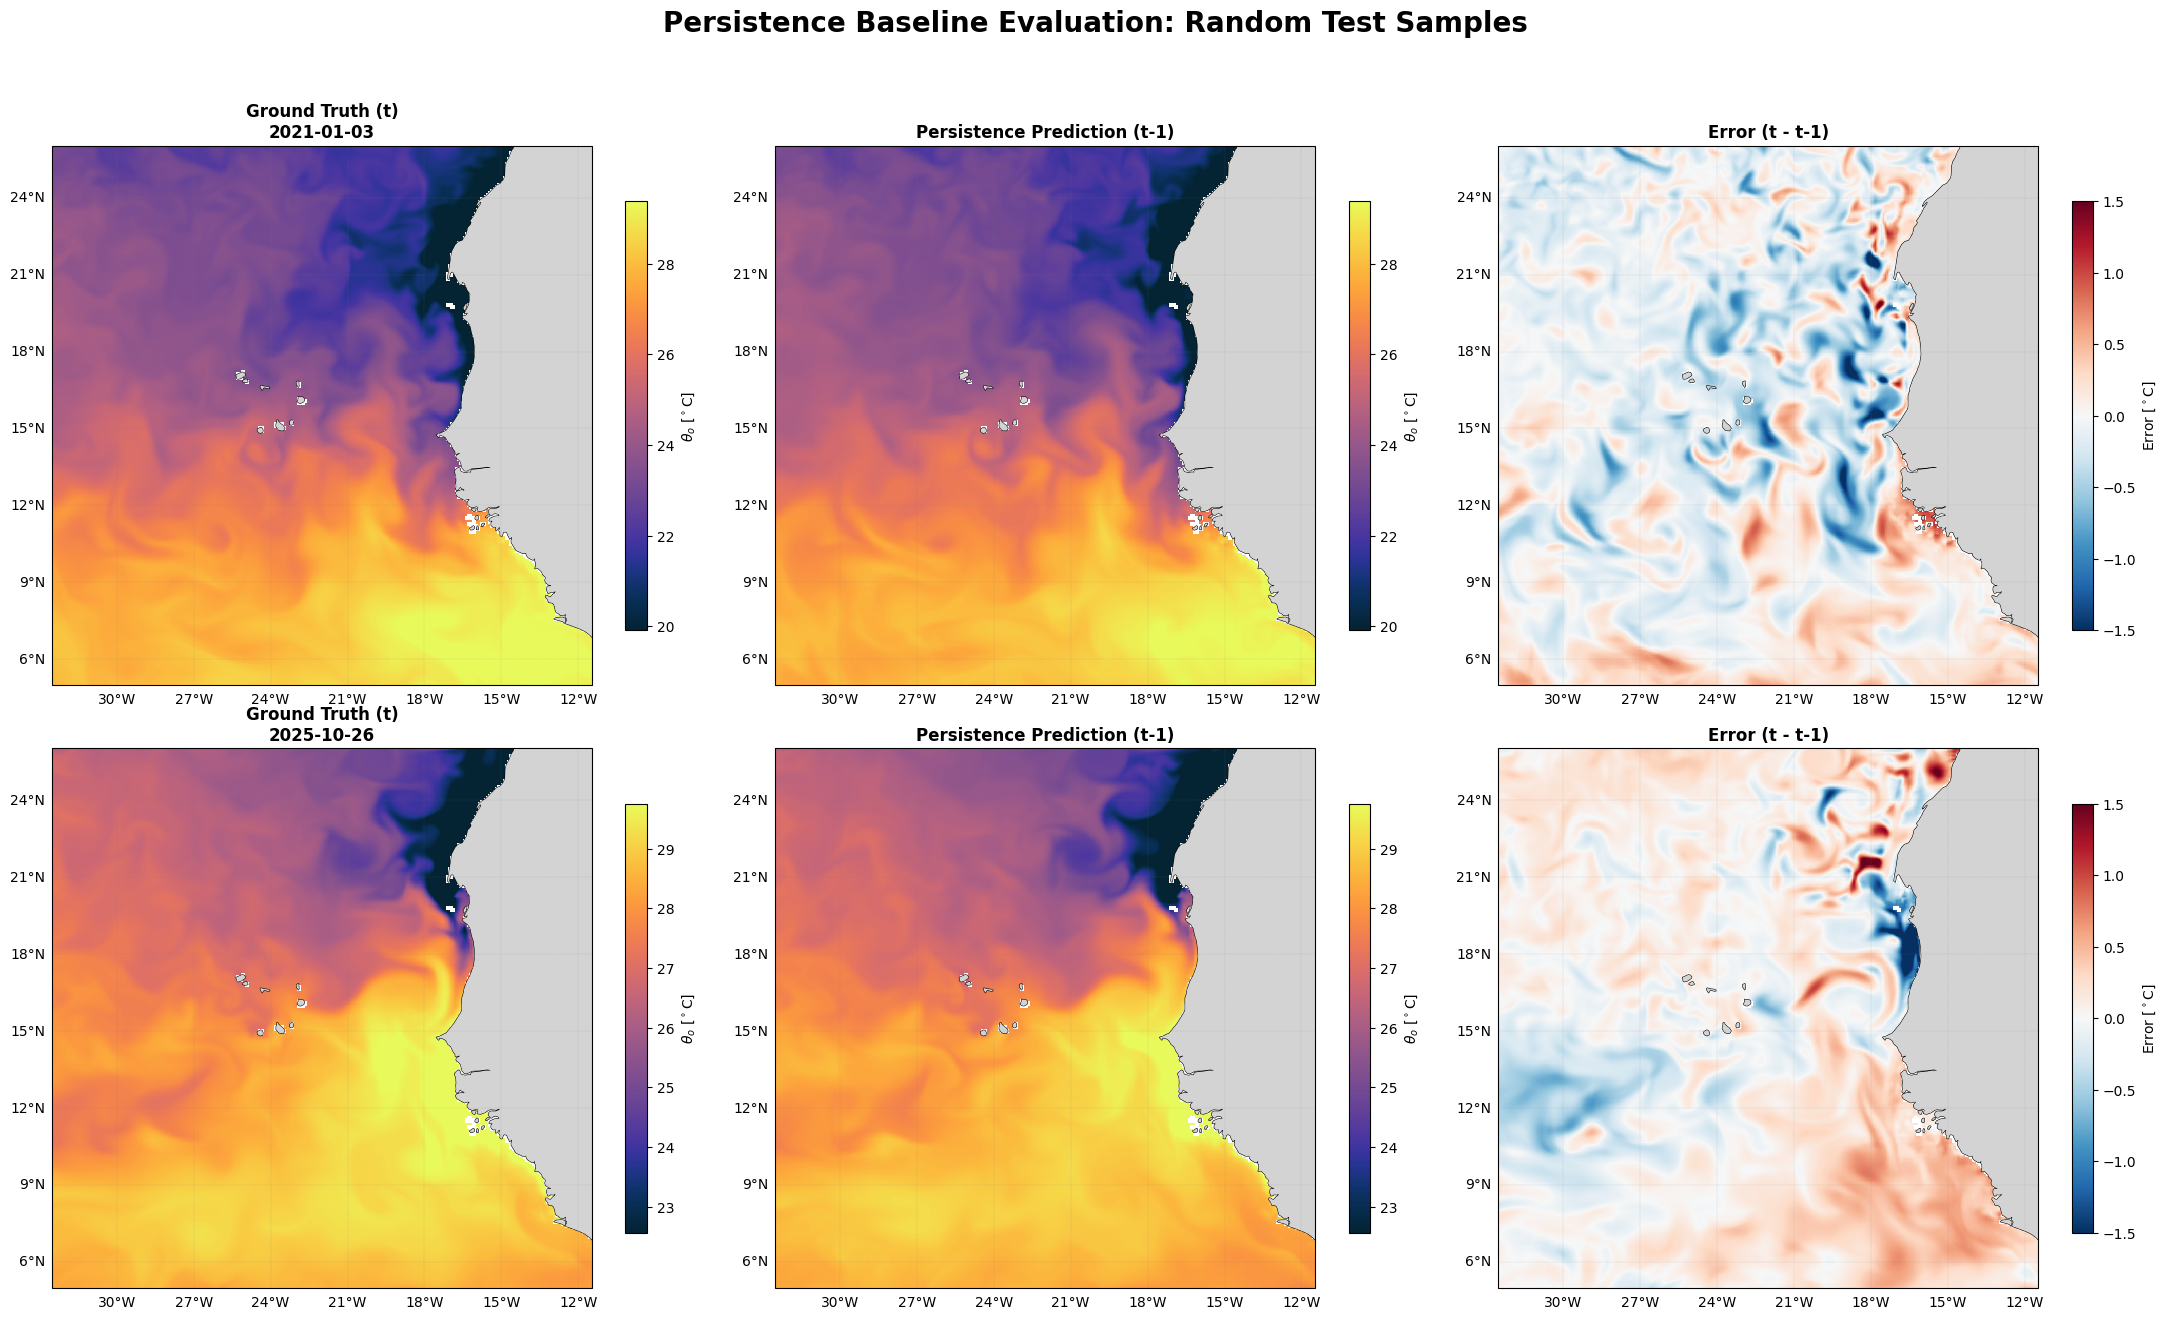

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

# 1. Coordinate Setup
lons = sst_dataset.longitude.values
lats = sst_dataset.latitude.values

# 2. Select two different random timesteps from the test set
indices = np.array([10,-10])

# 3. Plotting setup (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(22, 14), 
                        subplot_kw={'projection': ccrs.PlateCarree()})

for row, idx in enumerate(indices):
    # Data extraction
    target_snap = y_true[idx]
    pred_snap = y_pred[idx]
    diff_snap = target_snap - pred_snap
    
    # Calculate local 'robust' limits for this specific row
    v_min = np.nanpercentile(target_snap, 2)
    v_max = np.nanpercentile(target_snap, 98)
    
    sst_kwargs = {
        'cmap': cmocean.cm.thermal,
        'shading': 'auto',
        'transform': ccrs.PlateCarree(),
        'vmin': v_min,
        'vmax': v_max
    }

    # Column 0: Ground Truth
    im0 = axs[row, 0].pcolormesh(lons, lats, target_snap, **sst_kwargs)
    axs[row, 0].set_title(f"Ground Truth (t)\n{str(test_dates[idx])[:10]}", fontweight='bold')
    plt.colorbar(im0, ax=axs[row, 0], label=r'$\theta_o$ [$^\circ$C]', shrink=0.7)

    # Column 1: Persistence Prediction
    im1 = axs[row, 1].pcolormesh(lons, lats, pred_snap, **sst_kwargs)
    axs[row, 1].set_title(f"Persistence Prediction (t-1)", fontweight='bold')
    plt.colorbar(im1, ax=axs[row, 1], label=r'$\theta_o$ [$^\circ$C]', shrink=0.7)

    # Column 2: Difference (Error Map)
    im2 = axs[row, 2].pcolormesh(lons, lats, diff_snap, 
                                cmap='RdBu_r', 
                                transform=ccrs.PlateCarree(), 
                                vmin=-1.5, vmax=1.5,
                                shading='auto')
    axs[row, 2].set_title(f"Error (t - t-1)", fontweight='bold')
    plt.colorbar(im2, ax=axs[row, 2], label=r'Error [$^\circ$C]', shrink=0.7)

# 4. Global Cartographic Enhancements
for ax in axs.flat:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle("Persistence Baseline Evaluation: Random Test Samples", fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
